In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

In [3]:
!ls '/kaggle/input/brain-tumor-mri-dataset/Training/'

glioma	meningioma  notumor  pituitary


In [4]:
labels = {'glioma' : 0,'meningioma' : 1,'no tumor' : 2,'pituitary' : 3}

In [5]:
train_folders = [
    '/kaggle/input/brain-tumor-mri-dataset/Training/glioma/',
    '/kaggle/input/brain-tumor-mri-dataset/Training/meningioma/',
    '/kaggle/input/brain-tumor-mri-dataset/Training/notumor/',
    '/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/',
]
X_train = []
y_train = []
for i in range(len(train_folders)):
    folder_path = train_folders[i]
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            image = Image.open(file_path)
            image = image.resize((224, 224))
            if image.mode != 'RGB':
                image = image.convert('RGB')
            image = np.array(image)
            image = image.astype("float32") / 255.0
            X_train.append(image)
            y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)
print(len(X_train))
print(len(y_train))

5712
5712


In [6]:
test_folders = [
    '/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/',
    '/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/',
    '/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/',
    '/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/',
]
X_test = []
y_test = []
for i in range(len(test_folders)):
    folder_path = test_folders[i]
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            image = Image.open(file_path)
            image = image.resize((224, 224))
            if image.mode != 'RGB':
                image = image.convert('RGB')
            image = np.array(image)
            image = image.astype("float32") / 255.0
            X_test.append(image)
            y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)
print(len(X_test))
print(len(y_test))

1311
1311


In [ ]:
from tensorflow.keras.utils import to_categorical


y_train_one_hot = to_categorical(y_train, num_classes=4)
y_test_one_hot = to_categorical(y_test, num_classes=4)

In [8]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101


datagen = ImageDataGenerator(rescale=1./255)  
train_generator = datagen.flow(X_train, y_train_one_hot, batch_size=32)
num_classes = len(labels)
input_shape = (224, 224, 3)
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = True
for layer in base_model.layers[:100]:  
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train_one_hot, epochs = 30, batch_size = 40, verbose = 1,validation_data = (X_test, y_test_one_hot),callbacks=[lr_scheduler],class_weight=class_weights)


171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 190s 790ms/step - accuracy: 0.5891 - loss: 1.1552 - val_accuracy: 0.2891 - val_loss: 472.6555 - learning_rate: 0.0010
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 577ms/step - accuracy: 0.7490 - loss: 0.6206 - val_accuracy: 0.3921 - val_loss: 7.1849 - learning_rate: 0.0010
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 84s 587ms/step - accuracy: 0.8013 - loss: 0.5306 - val_accuracy: 0.5256 - val_loss: 1.9309 - learning_rate: 0.0010
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 84s 588ms/step - accuracy: 0.8133 - loss: 0.5118 - val_accuracy: 0.5957 - val_loss: 2.0507 - learning_rate: 0.0010
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 84s 589ms/step - accuracy: 0.8058 - loss: 0.5077 - val_accuracy: 0.3928 - val_loss: 4.1580 - learning_rate: 0.0010
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 593ms/step - accuracy: 0.8277 - loss: 0.4534 - val_accuracy: 0.7368 - val_loss: 0.9551 - learning_rate: 0.0010
Epoch 7/30
143

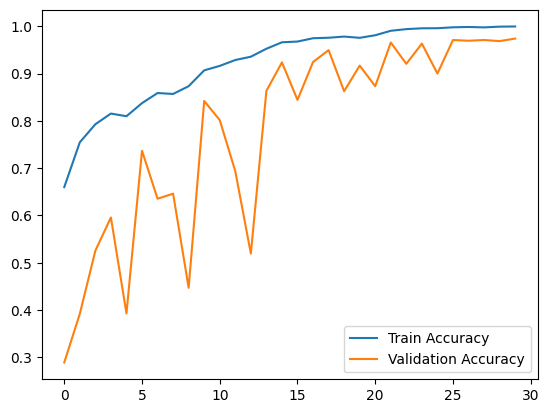

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [13]:
model.save('/kaggle/working/MRI_Brain_Tumor_classification_model_v1.h5')

In [ ]:
!ls '/kaggle/input/brain-tumor-classification-mri/'

In [14]:
train_folders = [
    '/kaggle/input/brain-tumor-classification-mri/Training/glioma_tumor',
    '/kaggle/input/brain-tumor-classification-mri/Training/meningioma_tumor',
    '/kaggle/input/brain-tumor-classification-mri/Training/no_tumor',
    '/kaggle/input/brain-tumor-classification-mri/Training/pituitary_tumor'
]
test_folders = [
    '/kaggle/input/brain-tumor-classification-mri/Testing/glioma_tumor',
    '/kaggle/input/brain-tumor-classification-mri/Testing/meningioma_tumor',
    '/kaggle/input/brain-tumor-classification-mri/Testing/no_tumor',
    '/kaggle/input/brain-tumor-classification-mri/Testing/pituitary_tumor'
]
X_quiz = []
y_quiz = []
for i in range(len(train_folders)):
    folder_path = train_folders[i]
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            image = Image.open(file_path)
            image = image.resize((224, 224))
            if image.mode != 'RGB':
                image = image.convert('RGB')
            image = np.array(image)
            image = image.astype("float32") / 255.0
            X_quiz.append(image)
            y_quiz.append(i)

for i in range(len(test_folders)):
    folder_path = test_folders[i]
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            image = Image.open(file_path)
            image = image.resize((224, 224))
            if image.mode != 'RGB':
                image = image.convert('RGB')
            image = np.array(image)
            image = image.astype("float32") / 255.0
            X_quiz.append(image)
            y_quiz.append(i)

X_quiz = np.array(X_quiz)
y_quiz = np.array(y_quiz)
print(len(X_quiz))
print(len(y_quiz))

3264
3264


In [16]:
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

102/102 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.71      0.83       926
  meningioma       0.84      1.00      0.91       937
     notumor       0.90      1.00      0.95       500
   pituitary       0.94      0.98      0.96       901

    accuracy                           0.91      3264
   macro avg       0.92      0.92      0.91      3264
weighted avg       0.92      0.91      0.91      3264

Overall Accuracy: 91.24%


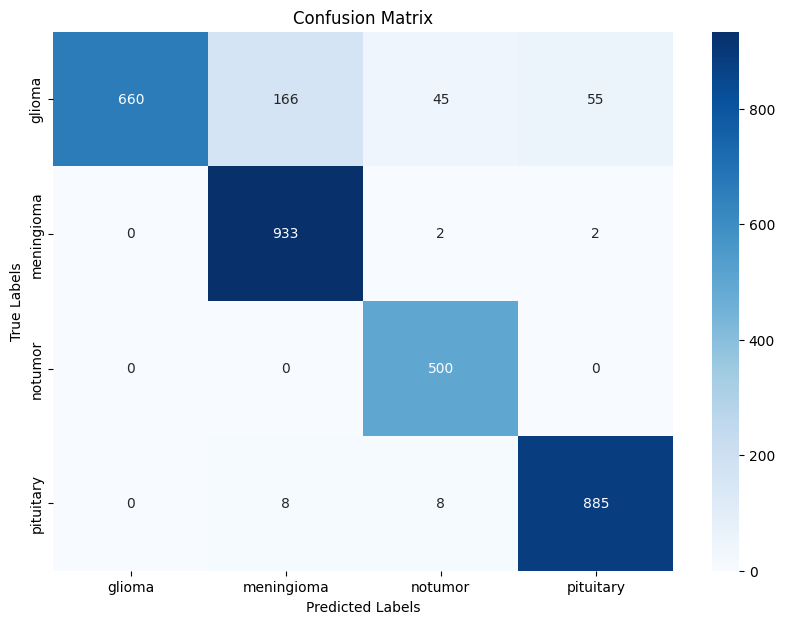

In [ ]:
y_pred = model.predict(X_quiz)
y_pred_classes = np.argmax(y_pred, axis=1)
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns


report = classification_report(y_quiz, y_pred_classes, target_names=class_labels)
print("Classification Report:")
print(report)


accuracy = accuracy_score(y_quiz, y_pred_classes)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")


conf_matrix = confusion_matrix(y_quiz, y_pred_classes)


plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

102/102 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step


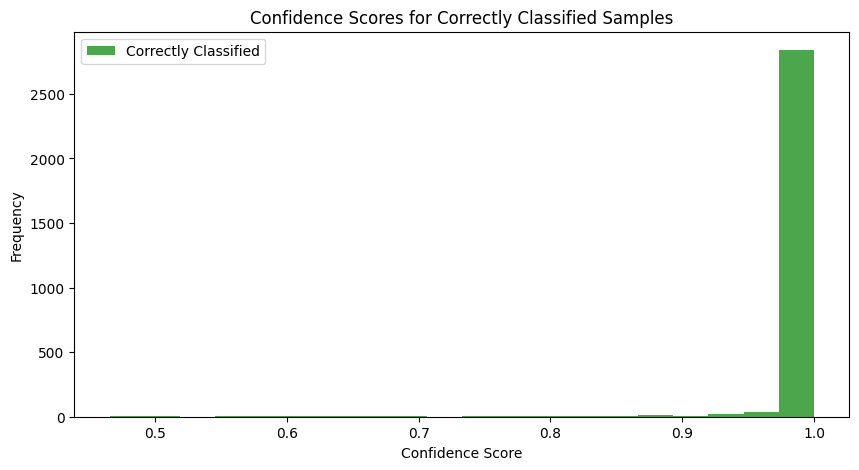

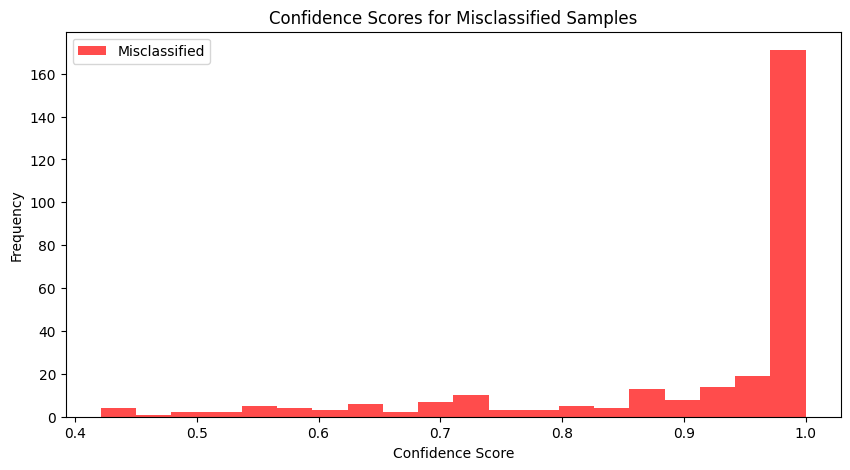

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


y_probs = model.predict(X_quiz)  
y_pred_classes = np.argmax(y_probs, axis=1)  


confidence_scores = np.max(y_probs, axis=1)


correct_indices = np.where(y_pred_classes == y_quiz)[0]
misclassified_indices = np.where(y_pred_classes != y_quiz)[0]


plt.figure(figsize=(10, 5))
plt.hist(confidence_scores[correct_indices], bins=20, color='green', alpha=0.7, label='Correctly Classified')
plt.title('Confidence Scores for Correctly Classified Samples')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.hist(confidence_scores[misclassified_indices], bins=20, color='red', alpha=0.7, label='Misclassified')
plt.title('Confidence Scores for Misclassified Samples')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

102/102 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step


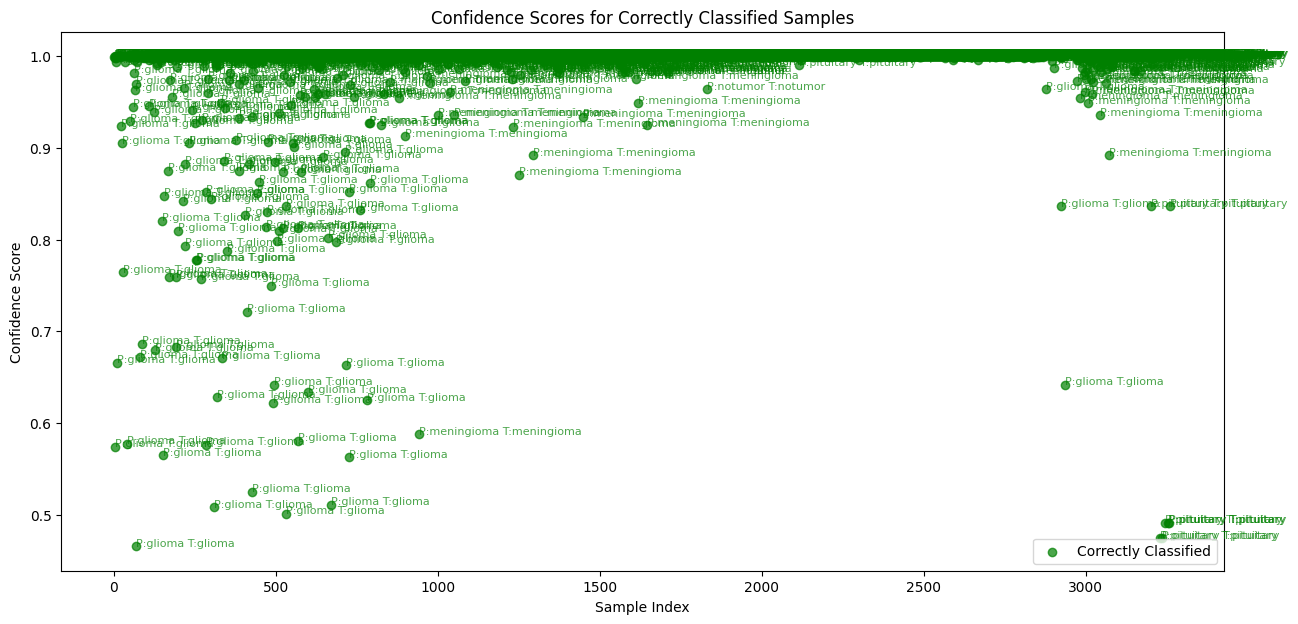

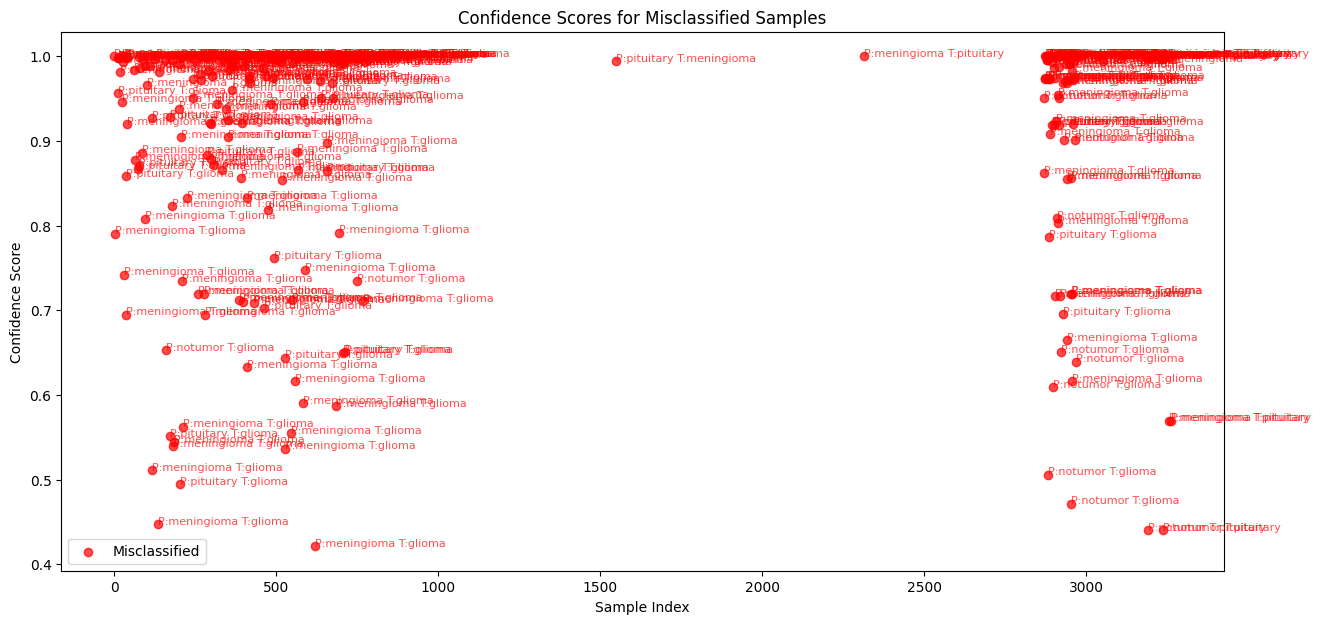

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


y_probs = model.predict(X_quiz)  
y_pred_classes = np.argmax(y_probs, axis=1)  


confidence_scores = np.max(y_probs, axis=1)


correct_indices = np.where(y_pred_classes == y_quiz)[0]
misclassified_indices = np.where(y_pred_classes != y_quiz)[0]


y_pred_labels = [class_labels[i] for i in y_pred_classes]
y_true_labels = [class_labels[i] for i in y_quiz]


plt.figure(figsize=(15, 7))
plt.scatter(correct_indices, confidence_scores[correct_indices], color='green', label='Correctly Classified', alpha=0.7)
for i in correct_indices:
    plt.text(i, confidence_scores[i], f'P:{y_pred_labels[i]} T:{y_true_labels[i]}', fontsize=8, color='green', alpha=0.7)
plt.title('Confidence Scores for Correctly Classified Samples')
plt.xlabel('Sample Index')
plt.ylabel('Confidence Score')
plt.legend()
plt.show()


plt.figure(figsize=(15, 7))
plt.scatter(misclassified_indices, confidence_scores[misclassified_indices], color='red', label='Misclassified', alpha=0.7)
for i in misclassified_indices:
    plt.text(i, confidence_scores[i], f'P:{y_pred_labels[i]} T:{y_true_labels[i]}', fontsize=8, color='red', alpha=0.7)
plt.title('Confidence Scores for Misclassified Samples')
plt.xlabel('Sample Index')
plt.ylabel('Confidence Score')
plt.legend()
plt.show()